In [1]:
!pip install ultralytics supervision -q

In [2]:
import numpy as np
import supervision as sv
import cv2
from ultralytics import YOLO


In [3]:
# Initialize YOLO model (Make sure to import YOLO from the appropriate library)
yolo = YOLO("yolov8m.pt")  # Update with the actual path to your YOLO model weights

# Specify the path to the video file
VIDEO = r'/content/output_video (online-video-cutter.com).mp4'


colors = sv.ColorPalette.default()
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info



VideoInfo(width=800, height=600, fps=20, total_frames=201)

In [4]:
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)

iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

In [5]:
polygons = [
  np.array([(290, 597), (331, 560), (376, 513), (406, 459), (439, 412), (464, 354), (460, 309), (434, 269), (400, 227), (361, 197), (308, 174), (230, 147), (154, 125), (71, 102), (70, 120), (79, 128), (109, 141), (146, 152), (178, 165), (218, 185), (247, 203), (284, 228), (311, 258), (337, 299), (340, 348), (316, 398), (286, 438), (257, 465), (226, 491), (185, 525), (157, 549), (119, 584), (110, 597)


  ]),
  np.array([(322, 591), (380, 554), (445, 488), (491, 420), (523, 369), (518, 312), (493, 263), (463, 237), (413, 206), (370, 186), (292, 155), (229, 134), (166, 111), (67, 84), (80, 66), (169, 93), (377, 143), (556, 188), (730, 240), (791, 264), (794, 374), (718, 312), (673, 275), (550, 215), (592, 252), (638, 297), (661, 344), (664, 398), (643, 449), (605, 494), (548, 560), (506, 597)

  ])
]

In [9]:
zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=0,
        text_thickness=4,
        text_scale=2
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=0,
        text_thickness=0,
        text_scale=0
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = yolo(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

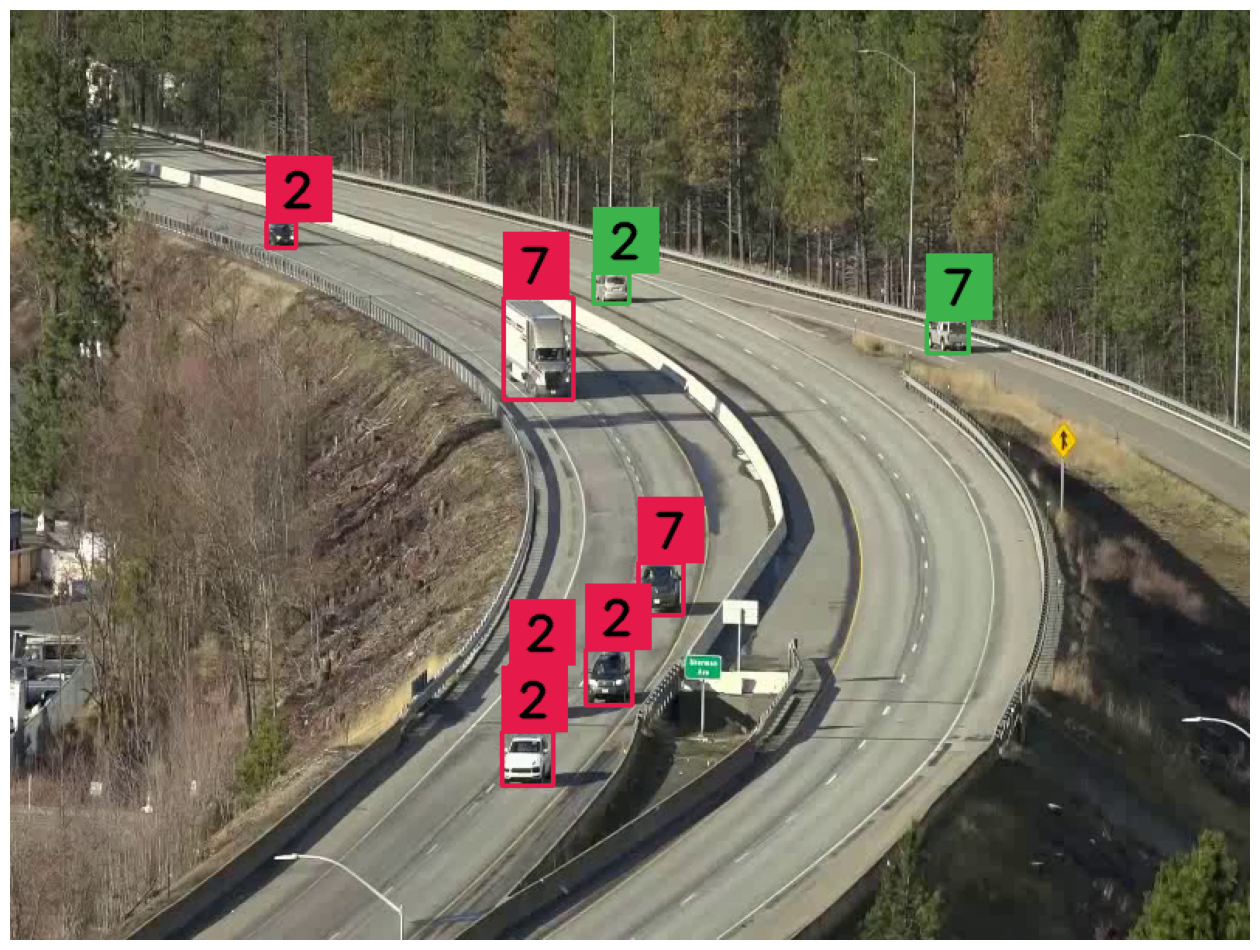

In [7]:
results = yolo(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)

sv.plot_image(frame, (16, 16))

In [10]:
sv.process_video(source_path=VIDEO, target_path="out_video.mp4", callback=process_frame)